### Measure PSI with current prod data and past dev
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load final data computed locally
# df = pd.read_feather("../../data/combined_all_features/combined_1613851268.feather") 
# we've previous sent combined_1613851268.feather to s3, let's download it
# dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/dev-data.parquet"
dev_path = "s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/data/tb-dev/modeling_df_final_2020-05-14.feather"
df = pd.read_feather(dev_path)
df = mu.preprocess(df)
df.sample_date.value_counts(), df.shape

(2019-12-31 00:00:00    61131
 2019-10-19 00:00:00    49524
 2019-08-07 00:00:00    40206
 2019-05-26 00:00:00    26006
 2019-03-15 00:00:00    20671
                        ...  
 2019-01-23 17:51:04        1
 2019-08-30 07:43:54        1
 2019-12-26 11:13:59        1
 2019-11-14 08:53:56        1
 2019-08-30 11:29:08        1
 Name: sample_date, Length: 389036, dtype: int64,
 (1086183, 47))

<AxesSubplot:>

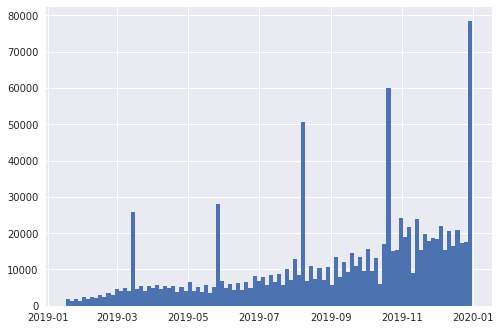

In [3]:
df.sample_date.hist(bins=100)

In [4]:
dev_snapshot_date = str(df.sample_date.max()).split()[0]
prod_snapshot_date = "2021-02-19"
df_dev = df[df.sample_date == df.sample_date.max()]
df_dev.sample_date.value_counts(), df_dev.shape

(2019-12-31    61131
 Name: sample_date, dtype: int64,
 (61131, 47))

In [5]:
df_prod = pd.read_parquet(f's3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/prod-data-{prod_snapshot_date}.parquet')

In [6]:
# preprocess
df_dev = mu.preprocess(df_dev)

In [7]:
# load model from s3
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

In [11]:
artifact_dir = "../../artifacts/monitoring-2021Q1/psi" 

### Score Level
---

Reload data from dev in 2020-01 after the dev period for development

In [16]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
# artifacts path
artifact_path = "../../artifacts/monitoring-2021Q1/psi" 
os.makedirs(artifact_path, exist_ok=True)

# load configs
with open("../../config.json", "r") as f:
    config = json.load(f)

# dev data get and process
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/dev-data.parquet"
df = pd.read_parquet(dev_path)
df = mu.prep_customer_data(df)
    
# find the first day to start monitoring
dev_snapshot_date = pd.to_datetime("2020-01-01")
prod_snapshot_date = "2021-02-19"
df_dev = df[df.sample_date == dev_snapshot_date]
display(df_dev.sample_date.value_counts(), df_dev.shape)

# prod data
df_prod = pd.read_parquet(f's3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/prod-data-{prod_snapshot_date}.parquet')

# load model from s3
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

2020-01-01    165849
Name: sample_date, dtype: int64

(165849, 98)

In [18]:
df_dev["model_pred"] = model.predict_proba(df_dev[model.feature_name_])[:,1]
df_dev["model_score"] = mu.scale_scores(df_dev["model_pred"])

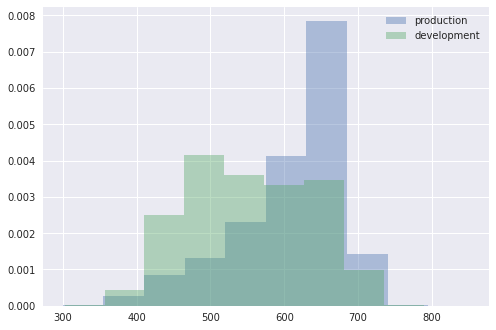

In [19]:
df_prod.model_score.hist(bins=10, alpha=0.4, density=True, label="production")
df_dev.model_score.hist(bins=10, alpha=0.4, density=True, label="development")
plt.legend()

In [20]:
psi_df = mntr.get_psi(df_dev.model_score.to_frame(), 
                      df_prod.model_score.to_frame()).round(5)
psi_df.to_csv(os.path.join(artifact_dir, f"score-psi-dev{dev_snapshot_date}-prod{prod_snapshot_date}.csv"), index=False)
psi_df

,feature,psi
0,model_score,0.5422
